# Converting a classifier into a generative model

*This notebook first appeared as a [blog post](//betatim.github.io/posts/generative-classifier) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2016, Tim Head and Baptiste Ottino*
*Feel free to use, distribute, and modify with the above attribution.*

This blog post explores a method from [Learning Generative Models via Discriminative Approaches](http://pages.ucsd.edu/~ztu/publication/cvpr07_gdl.pdf) by Tu. It allows you to
convert a classifier into a generative model.

Generative models are useful to create yourself more trainign examples or to simulate
your whole experiment, like the ones at [CERN](//home.cern).

This post was written together with Baptiste Ottino.

We will show you how you can convert a random forest into a generative model in a few steps.

As usual, some imports and setup first.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Target distribution

Let's try and create a generative model for a problem with two dimensions. The distribution
itself will be a square inside a circle. We chose the problem because it is a bit tricky
to get right with a KDE or GMM.

(-4, 4)

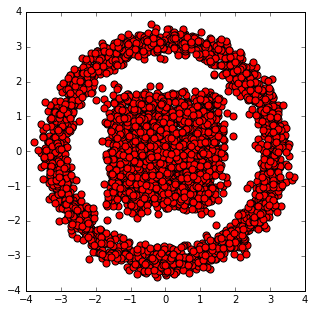

In [24]:
rng = np.random.RandomState(14)

n_samples = 2000
X = 200 * rng.rand(n_samples, 1) - 100
X2 = 3 * rng.rand(n_samples, 2) - 1.5

y1 = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
X_target = np.vstack((y1, X2))
X_target += rng.normal(scale=0.2, size=X_target.shape)

plt.figure(1, figsize=(5,5))
plt.scatter(X_target[:, 0], X_target[:, 1], c='r', s=50, marker='o')
plt.xlim([-4, 4]); plt.ylim([-4, 4])

## The classifier

We use a random forest as classifier. Have a play with the `max_depth` and number of `n_estimators`.

In [25]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=15, n_estimators=40, random_state=10, n_jobs=5)

## The method

Tu's method starts with a uniform distribution in feature space (refered to as pseudo-negatives), trains a classifier to separate pseudo-negatives from real samples, bootstrap, and then repeat.

What is Boostrapping? Sampling with replacement from a existing sample. In our case samples
are weighted by the classifier's estimate of which class the samples belongs to.

In [26]:
def bootstrap(xs, sample_prob, sample_size):
    x_indices = np.random.choice(np.arange(len(xs)), size=sample_size, p=sample_prob)
    x_new = xs[x_indices]
    return np.array(x_new)

(-4, 4)

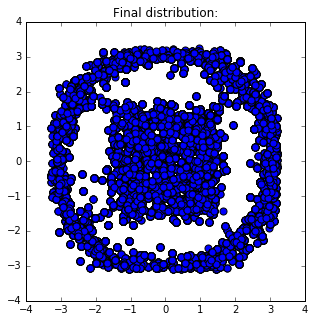

In [37]:
# the pseudo-negatives
X_pn = rng.uniform(-4,4, (50000, 2))

# assign positive labels to our target distribution
y_target = np.ones((len(X_target), 1), dtype=bool)

# negative labels for the pseudo-negatives
y_pn = np.zeros((len(X_pn), 1), dtype=bool)

# Recursive pseudo-negatives -> bootstrapping algorithm
for i in range(70):
    #X = np.vstack((target, X_train))
    X = np.vstack((X_target, X_pn))
    y = np.vstack((y_target, y_pn))
    y = y.ravel()
    
    # Trains the classifier
    clf.fit(X, y)
    
    p = clf.predict_proba(X_pn)[:,1]
    p = p / np.sum(p)

    X_pn = bootstrap(X_pn, sample_prob=p, sample_size=len(X_pn))

    if i%10 == 0 and False:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        ax.set_title("After {0} iterations:".format(i+1))
        ax.scatter(X_pn[:, 0], X_pn[:, 1], c='b', s=50, marker='o')
        ax.set_xlim([-4, 4]); ax.set_ylim([-4, 4])
        
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_title("Final distribution:")
ax.scatter(X_pn[:, 0], X_pn[:, 1], c='b', s=50, marker='o')
ax.set_xlim([-4, 4]); ax.set_ylim([-4, 4])

## Crunch time

How do you determine the quality of your generative model? Simple. You train a classifier to
try and discriminate between real and fake samples. Below we use an `ExtraTreesClassifier`.

(4000, 2) (4000, 2)
score: 0.525 +/- 0.064


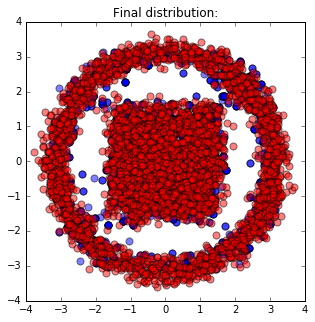

In [47]:
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd


#et_clf = ExtraTreesClassifier(random_state=10, max_depth=15, n_estimators=40)
et_clf = RandomForestClassifier(max_depth=15, n_estimators=180, random_state=10, n_jobs=5)

X_gen = X_pn.copy()
# Eliminates duplicates in a super inefficient way
#DF_gen = pd.DataFrame(X_gen)
#DF_gen = DF_gen.drop_duplicates()
#X_gen = DF_gen.values

X_gen, _ = train_test_split(X_gen, train_size=len(X_target))
print(X_gen.shape, X_target.shape)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_title("Final distribution:")
ax.scatter(X_gen[:, 0], X_gen[:, 1], c='b', s=50, marker='o', alpha=0.5)
ax.scatter(X_target[:, 0], X_target[:, 1], c='r', s=50, marker='o', alpha=0.5)
ax.set_xlim([-4, 4]); ax.set_ylim([-4, 4])


# Label the data
y_target = np.ones((len(X_target), 1), dtype=bool)
y_gen = np.zeros((len(X_gen), 1), dtype=bool)

X = np.vstack((X_target, X_gen))
y = np.vstack((y_target, y_gen))
y = y.ravel()
    
scores = cross_val_score(et_clf, X, y, cv=5)
print('score: {0:.3f} +/- {1:.3f}'.format(scores.mean(), scores.std()))

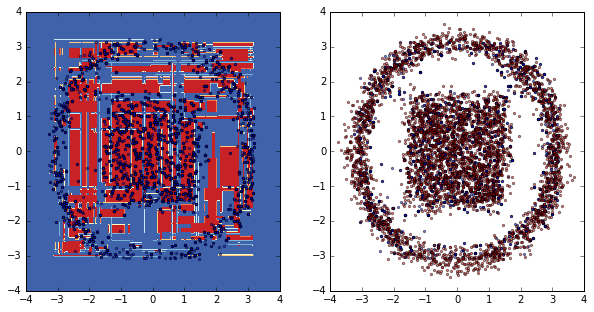

In [56]:
et_clf = RandomForestClassifier(max_depth=15, n_estimators=10, random_state=10, n_jobs=5)

XX, XX_, yy, yy_ = train_test_split(X, y, train_size=0.8)
et_clf.fit(XX, yy)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = et_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

cs = ax1.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
ax1.scatter(X_gen[:, 0], X_gen[:, 1], c='b', s=5, marker='o', alpha=0.5)
ax2.scatter(X_gen[:, 0], X_gen[:, 1], c='b', s=5, marker='o', alpha=0.5)
ax2.scatter(X_target[:, 0], X_target[:, 1], c='r', s=5, marker='o', alpha=0.5)
for ax in (ax1, ax2):
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

In [ ]:
X_gen = X_pn.copy()
DF_gen = pd.DataFrame(X_gen)
DF_gen_dedupe = DF_gen.drop_duplicates()

In [ ]:
DF_gen.describe()

In [ ]:
DF_gen_dedupe.describe()

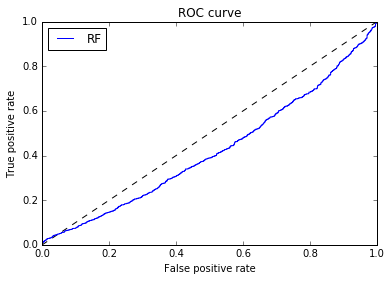

In [36]:
from sklearn.metrics import roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

et_clf.fit(X_train, y_train)

y_pred_rf = et_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()